In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(cowplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
psize = function(w, h)
{
    options(repr.plot.height = h, repr.plot.width = w)
}

In [3]:
process_flagstat = function(file)
{
    data = fread(file, data.table = F, fill = T)
    rownames(data) = c(1:nrow(data))

    qc_fin = data.frame(matrix(nrow = 1, ncol = 0)) 
    qc_fin$total = data[1,1]
#     qc_fin$secondary = data[2,1]
#     qc_fin$supplementary = data[3,1]
    qc_fin$duplicates = data[4,1]
    qc_fin$mapped = data[5,1]
    qc_fin$pct_mapped = as.numeric(gsub("[(]", "", unlist(strsplit(data[5,5], ":"))[1])) * 100
    qc_fin$paired = data[6,1]
#     qc_fin$read1 = data[7,1]
#     qc_fin$read2 = data[8,1]
    qc_fin$prop_paired = data[9,1]
    qc_fin$pct_prop_paired = as.numeric(gsub("[(]", "", unlist(strsplit(data[9,6], ":"))[1])) * 100
#     qc_fin$singletons = data[11,1]
    return(qc_fin)
}

In [40]:
uuids = list.files("/projects/PPC/pipeline/ATAC-Seq/encode")

In [26]:
qc_list = list()

In [41]:
for (uuid in uuids)
{
    if (!uuid %in% names(qc_list))
    {
        tryCatch(
        {
            message(uuid, appendLF = F)
            dir = paste("/projects/PPC/pipeline/ATAC-Seq/encode", uuid, sep = "/")
            qc_dir = paste(dir, "qc", sep = "/")
            qc_fin = data.frame(uuid = uuid)

            # Before filtering
            file1 = paste(qc_dir, "Aligned.sorted.flagstat.qc", sep = "/")
            file2 = paste(qc_dir, "Aligned.sorted.filt.dup.qc", sep = "/")
            file3 = paste(qc_dir, "Aligned.sorted.filt.nodup.flagstat.qc", sep = "/")
           
            qc1 = process_flagstat(file1)

            qc2 = fread(cmd = paste("tail -n +7", file2, "| head -2"), data.table = F)
            colnames(qc2) = tolower(colnames(qc2))
            qc2$percent_duplication = qc2$percent_duplication * 100

            qc3 = process_flagstat(file3)
            colnames(qc3) = paste0(colnames(qc3), ".filt")

            qc = do.call(cbind, list(data.frame(uuid = uuid), qc1, qc2, qc3))

            peaks = list.files(paste(dir, "peaks", sep = "/"))

            bed = read.table(paste(dir, "peaks", "narrow_tagAlign_peaks_noblacklist.narrowPeak", sep = "/"))
            qc$peaks= nrow(bed)
            qc$auto_peaks = nrow(bed[bed$V1 %in% paste0("chr", c(1:22)),])
            
            txt = paste(dir, "peaks", "narrow_tagAlign_peaks_noblacklist.frip.txt", sep = "/")
            qc$reads_in_peaks = as.numeric(readLines(txt))
            qc$frip = as.numeric(readLines(txt)) / (qc$total.filt / 2) * 100
            
            qc_list[[uuid]] = qc

        
        }, error = function(cond)
        {
            message(paste(uuid, "check!"), appendLF = F)
            message(paste(dir, "peaks", "narrow_tagAlign_peaks_noblacklist.narrowPeak", sep = "/"))
            print(cond)
        }, warning = function(cond)
        {
            message("", appendLF = F)
        })
    }
        
        
}



2707259c-f2b0-4ebc-acb1-60aadd0e34d5
717db387-811d-47c8-ac08-3aa6475de12d
717db387-811d-47c8-ac08-3aa6475de12d check!
/projects/PPC/pipeline/ATAC-Seq/encode/717db387-811d-47c8-ac08-3aa6475de12d/peaks/narrow_tagAlign_peaks_noblacklist.narrowPeak



<simpleError in read.table(paste(dir, "peaks", "narrow_tagAlign_peaks_noblacklist.narrowPeak",     sep = "/")): no lines available in input>


7d4df197-11f9-4632-99df-3552ca387d44



In [42]:
qc_summary = as.data.frame(rbindlist(qc_list)) %>% select(-library) 
qc_summary$pct_filtered = qc_summary$total.filt / qc_summary$total * 100
# qc_summary$frip = qc_summary$reads_in_peaks / (qc_summary$total.filt / 2) * 100
summary(qc_summary$frip)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  35.25   59.00   64.70   62.64   68.03   82.77 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


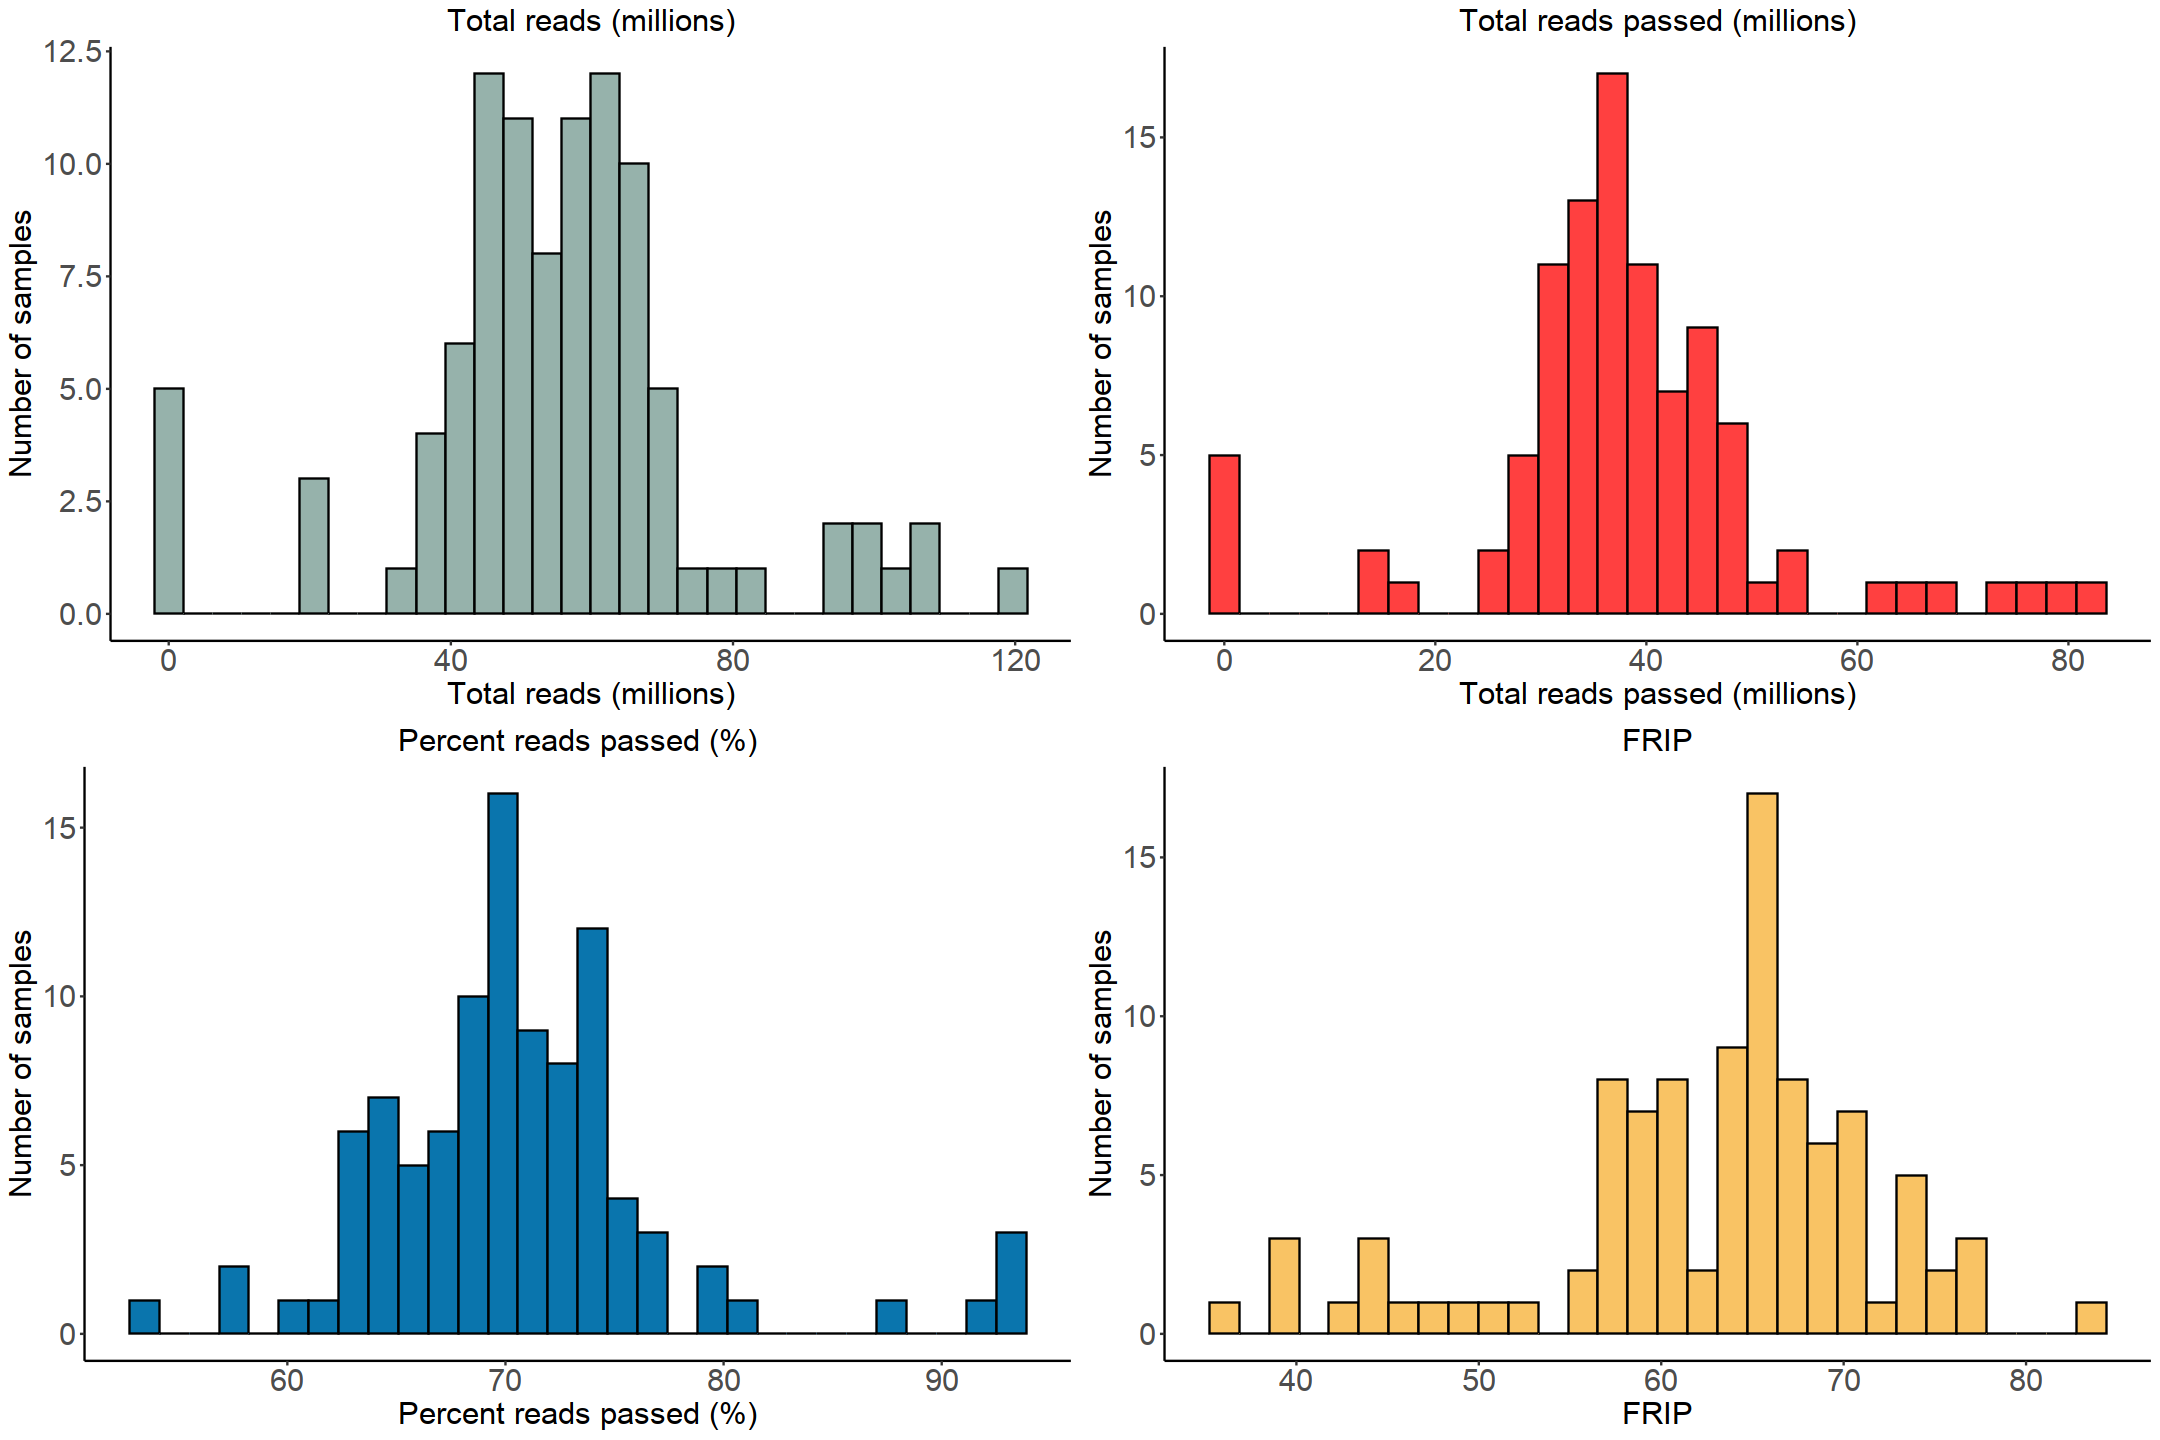

In [39]:
p1 = ggplot(qc_summary, aes(x = total / 1e6)) + geom_histogram(color = "black", fill = "#96b2ab") + 
    theme_classic() + 
    theme(axis.text = element_text(size = 18), 
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, hjust = 0.5)
         ) + 
    xlab("Total reads (millions)") + ylab("Number of samples") + ggtitle("Total reads (millions)")

p2 = ggplot(qc_summary, aes(x = total.filt / 1e6)) + geom_histogram(color = "black", fill = "#ff4040") + 
    theme_classic() + 
    theme(axis.text = element_text(size = 18), 
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, hjust = 0.5)
         ) + 
    xlab("Total reads passed (millions)") + ylab("Number of samples") + ggtitle("Total reads passed (millions)")

p3 = ggplot(qc_summary, aes(x = pct_filtered)) + geom_histogram(color = "black", fill = "#0a75ad") + 
    theme_classic() + 
    theme(axis.text = element_text(size = 18), 
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, hjust = 0.5)
         ) + 
    xlab("Percent reads passed (%)") + ylab("Number of samples") + ggtitle("Percent reads passed (%)")

p4 = ggplot(qc_summary, aes(x = frip)) + geom_histogram(color = "black", fill = "#f9c364") + 
    theme_classic() + 
    theme(axis.text = element_text(size = 18), 
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, hjust = 0.5)
         ) +
    xlab("FRIP") + ylab("Number of samples") + ggtitle("FRIP")

psize(w = 18, h = 12)
plot_grid(p1, p2, p3, p4, nrow = 2)

# Compare peak files

In [54]:
no_flag = fread("../../../work/2023_0720/tagAlign_noinput_peaks.narrowPeak", data.table = F)
no_flag$id = paste(no_flag$V1, no_flag$V2, no_flag$V3, sep = "_")
no_flag$width = no_flag$V3 - no_flag$V2
no_flag = no_flag %>% select(id, V4, width) %>% distinct()
length(unique(no_flag$id))
summary(no_flag$width)

[1] 188870

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  150.0   218.0   387.0   558.8   777.0  4444.0 

In [56]:
flag = fread("../../../work/2023_0720/tagAlign_bedpe_peaks.narrowPeak", data.table = F)
flag$id = paste(flag$V1, flag$V2, flag$V3, sep = "_")
flag$width = flag$V3 - flag$V2
flag = flag %>% select(id, V4, width) %>% distinct()
length(unique(flag$id))
summary(flag$width)

[1] 407332

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   95.0   139.0   222.0   422.9   561.0  5577.0 

In [116]:
bam_flag = fread("../../../work/2023_0720/bam_bampe_peaks.narrowPeak", data.table = F)
bam_flag$id = paste(bam_flag$V1, bam_flag$V2, bam_flag$V3, sep = "_")
bam_flag$width = bam_flag$V3 - bam_flag$V2
bam_flag = bam_flag %>% select(id, V5, width) %>% distinct()
summary(bam_flag$width)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  126.0   191.0   328.0   587.1   770.0 23340.0 

In [117]:
bam_noflag = fread("../../../work/2023_0720/bam_noflag_peaks.narrowPeak", data.table = F)
bam_noflag$id = paste(bam_noflag$V1, bam_noflag$V2, bam_noflag$V3, sep = "_")
bam_noflag$width = bam_noflag$V3 - bam_noflag$V2
bam_noflag = bam_noflag %>% select(id, V5, width) %>% distinct()
summary(bam_noflag$width)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  150.0   193.0   336.0   512.7   705.0  4436.0 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


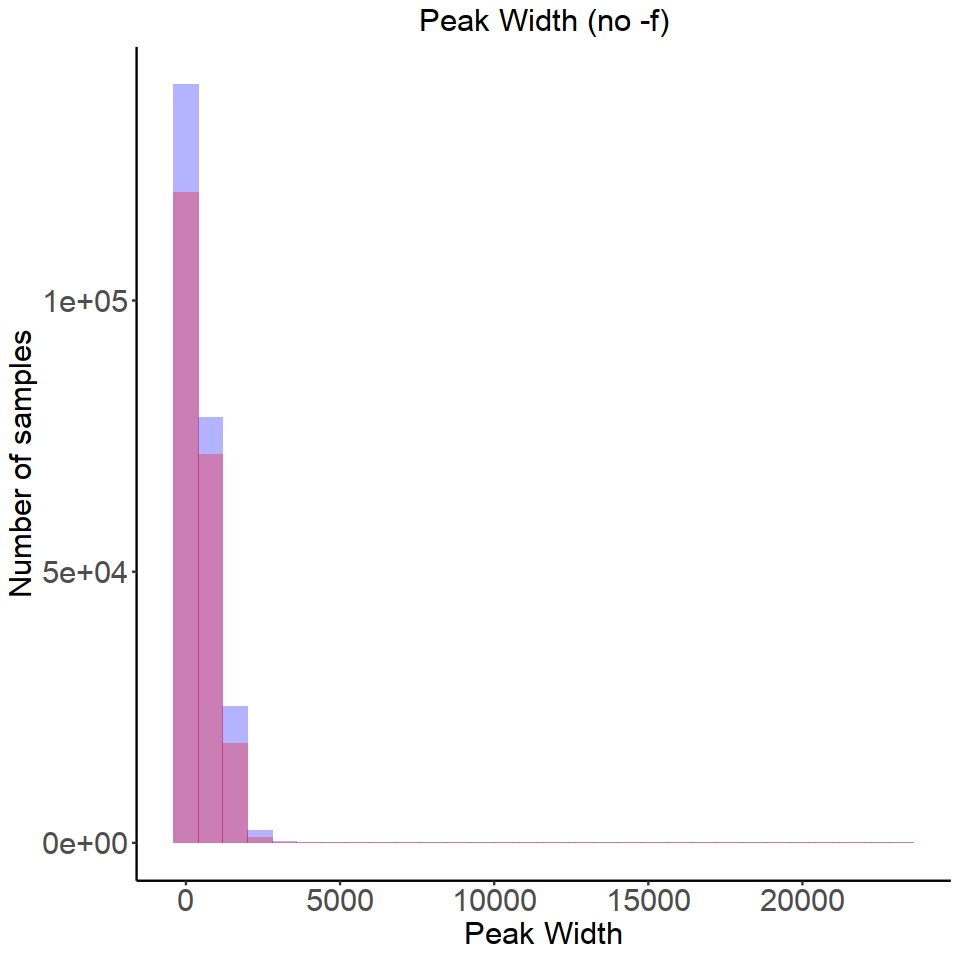

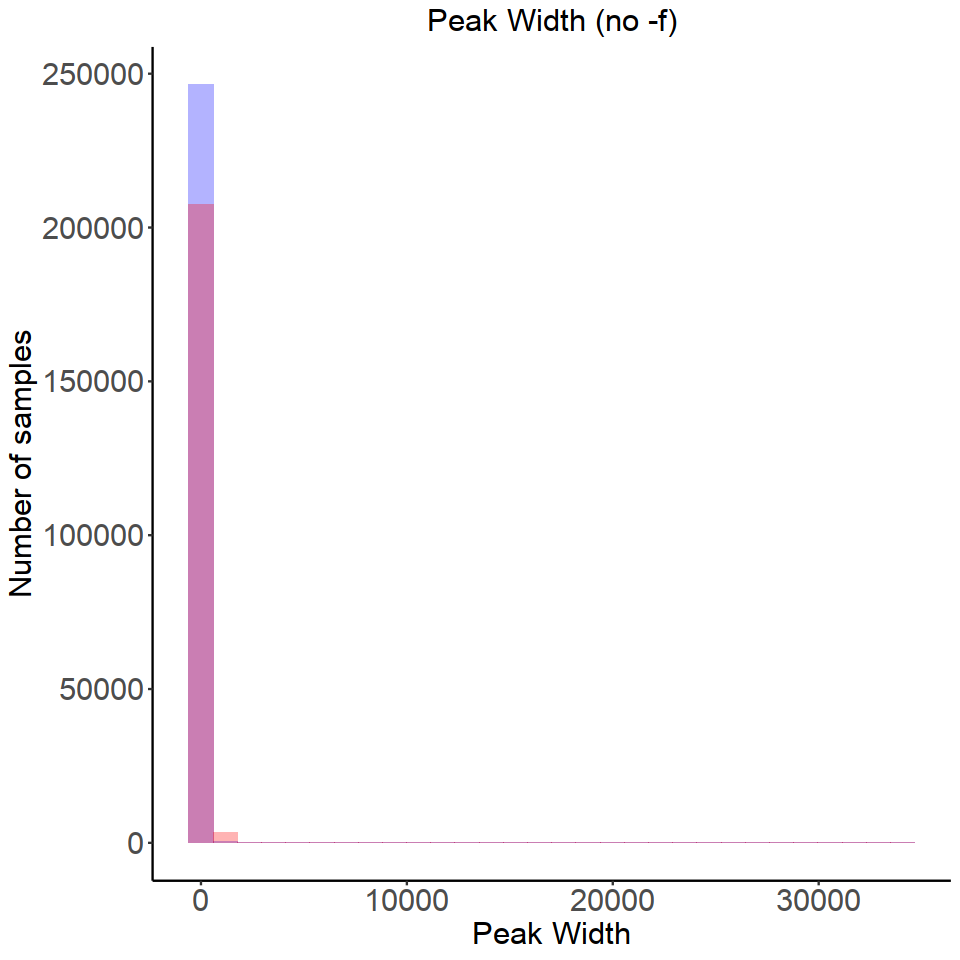

In [120]:
p1 = ggplot() + 
    theme_classic() + 
    theme(axis.text = element_text(size = 18), 
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, hjust = 0.5)
         ) +
    xlab("Peak Width") + ylab("Number of samples") + ggtitle("Peak Width (no -f)") + 
    geom_histogram(data = bam_flag, aes(x = width), fill = "blue", alpha = 0.3) + 
    geom_histogram(data = bam_noflag, aes(x = width), fill = "red", alpha = 0.3)
    
  
p1

p1 = ggplot() + 
    theme_classic() + 
    theme(axis.text = element_text(size = 18), 
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, hjust = 0.5)
         ) +
    xlab("Peak Width") + ylab("Number of samples") + ggtitle("Peak Width (no -f)") + 
    geom_histogram(data = bam_flag, aes(x = V5), fill = "blue", alpha = 0.3) + 
    geom_histogram(data = bam_noflag, aes(x = V5), fill = "red", alpha = 0.3)
    
  
p1

In [ ]:
bam="encode/60b2d6ab-534d-410d-bc70-a18887b74853/Aligned.sorted.filt.nodup.bam"
macs2 callpeak \
-t "${bam}" \
-n "jeff_bam" \
-B \
-g hs \
--shift -75 \
--extsize 150 \
--nomodel \
--call-summits \
--keep-dup all